In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Explore preprocessed features

## Installation and import of the needed libraries


In [11]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import and configuration setup


In [12]:
# python modules
import math
import os
import pickle

# 3rd party modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, StandardScaler, OrdinalEncoder, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline

# user modules
from utils import util_data, util_preprocess, util_plot, util_models

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [13]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.


In [14]:
pd.set_option("max_colwidth", 800)

In [15]:
df = pd.read_csv("data/processed/gsm.csv", sep=",")
df.head()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.30,1,0,1,0,1,1,4G,...,1,1,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.70,1,0,1,0,1,1,4G,...,1,1,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.00,1,0,1,1,1,1,4G,...,0,0,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0
3,304.00,2019.0,5.60,1,0,1,1,1,1,4G,...,0,0,1080.0,2220.0,64.0,4.0,12.2,1.0,8.0,1.0
4,110.00,2020.0,5.71,0,1,0,1,0,0,4G,...,0,0,720.0,1520.0,64.0,3.0,13.0,1.0,5.0,1.0


In [16]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of nan values: {df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of rows: 2199
Number of nan values: 0
Number of duplicated rows: 0


## Explore the dataset

### Split in train-test set

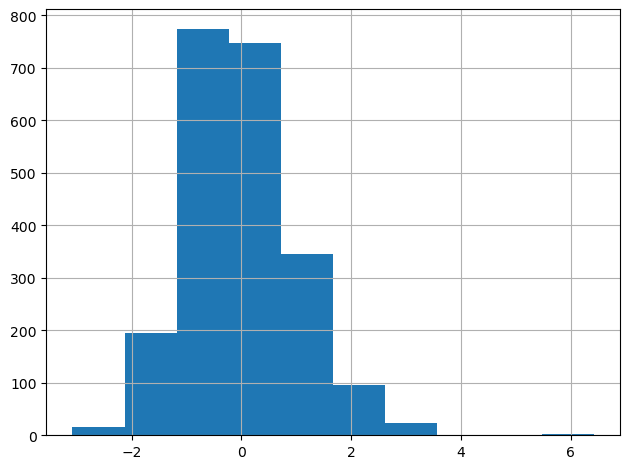

In [17]:
price = df.misc_price.clip(upper=None)
price = price.apply(np.log)

std_scaler = StandardScaler()
std_price = std_scaler.fit_transform(price.values.reshape(-1, 1))

pd.Series(std_price.flatten()).hist(bins=10)
plt.tight_layout()

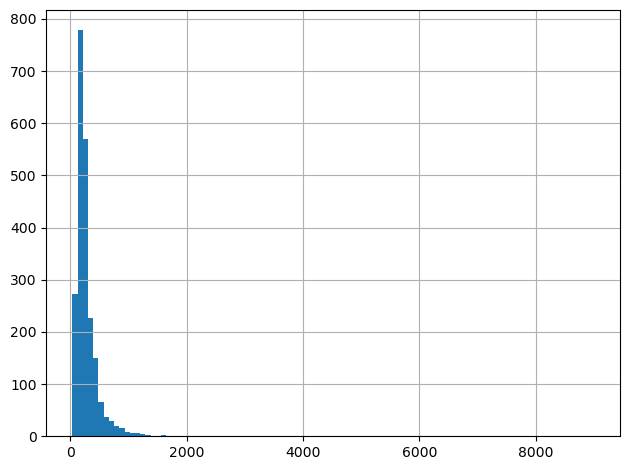

In [455]:
df.misc_price.hist(bins=100)
plt.tight_layout()

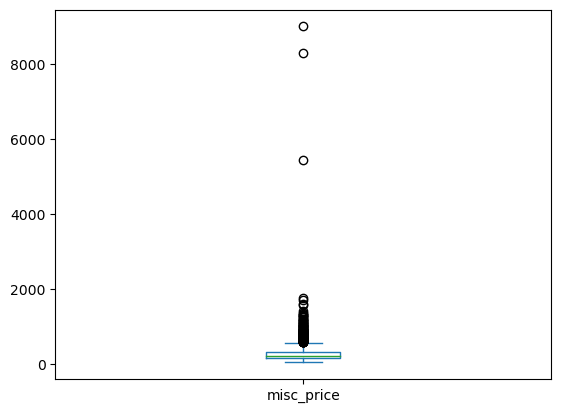

In [456]:
df.misc_price.clip(upper=None).plot.box()
plt.show()

Bin 0: 50.00 - 55.61 | 4
Bin 1: 55.61 - 61.84 | 4
Bin 2: 61.84 - 68.78 | 8
Bin 3: 68.78 - 76.49 | 10
Bin 4: 76.49 - 85.07 | 34
Bin 5: 85.07 - 94.61 | 34
Bin 6: 94.61 - 105.22 | 64
Bin 7: 105.22 - 117.02 | 53
Bin 8: 117.02 - 130.14 | 131
Bin 9: 130.14 - 144.73 | 67
Bin 10: 144.73 - 160.96 | 199
Bin 11: 160.96 - 179.02 | 97
Bin 12: 179.02 - 199.09 | 147
Bin 13: 199.09 - 221.42 | 256
Bin 14: 221.42 - 246.25 | 109
Bin 15: 246.25 - 273.86 | 215
Bin 16: 273.86 - 304.57 | 182
Bin 17: 304.57 - 338.73 | 98
Bin 18: 338.73 - 376.71 | 101
Bin 19: 376.71 - 418.96 | 92
Bin 20: 418.96 - 465.94 | 74
Bin 21: 465.94 - 518.19 | 50
Bin 22: 518.19 - 576.30 | 32
Bin 23: 576.30 - 640.93 | 29
Bin 24: 640.93 - 712.81 | 28
Bin 25: 712.81 - 792.74 | 16
Bin 26: 792.74 - 881.64 | 20
Bin 27: 881.64 - 980.51 | 11
Bin 28: 980.51 - 1090.46 | 10
Bin 29: 1090.46 - 1212.75 | 9
Bin 30: 1212.75 - 1348.75 | 6
Bin 31: 1348.75 - 1500.00 | 9


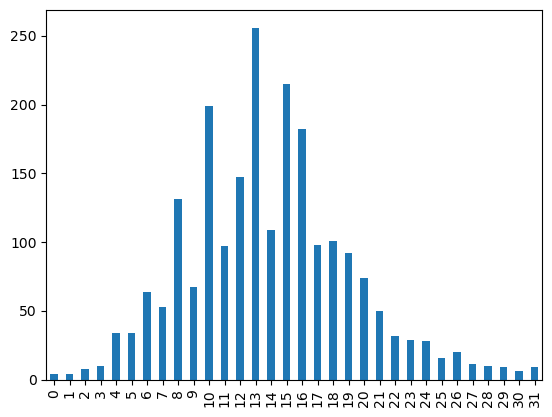

In [18]:
class LabelEncoder(FunctionTransformer):
    def __init__(self, bins="doane", **kwargs):
        self.bins = bins
        super().__init__(self.compute_label_encoding, kw_args={"bins": bins}, **kwargs)

    def compute_label_encoding(self, x, bins):
        _, bin_edges = np.histogram(x, bins=bins)
        self.bin_edges_ = [bin_edges]
        bin_edges[-1] = bin_edges[-1] + 1e-6
        return np.digitize(x, bin_edges, right=False) - 1
    
def clip_drop(x, a_min, a_max, clip=True):
    if clip:
        return np.clip(x, a_min, a_max)
    else:
        return x[(x >= a_min) & (x <= a_max)]


clip_fun = FunctionTransformer(clip_drop, validate=False, check_inverse=False, kw_args={"a_min": 50, "a_max": 1500, "clip": True})
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp)
label_enc = LabelEncoder(bins="auto", validate=False)
# label_enc = KBinsDiscretizer(n_bins=10, encode="ordinal", subsample=None, strategy="uniform")

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)
label_cat = label_pipeline.fit_transform(df.misc_price.values.reshape(-1, 1))

# get the frequency of each bin
label_cat_freq = pd.Series(label_cat.flatten()).value_counts().sort_index()

# convert bin edges without the logarithm
bin_edges = np.exp(label_pipeline[2].bin_edges_[0])
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f} | {label_cat_freq[i] if i in label_cat_freq else 0}")

# plot the frequency of each bin
label_cat_freq.plot.bar()
plt.show()

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=rng, shuffle=True, stratify=label_cat)

In [459]:
print(f"Number of rows in train set: {df_train.shape[0]}")
print(f"Number of rows in test set: {df_test.shape[0]}")

Number of rows in train set: 1759
Number of rows in test set: 440


In [20]:
# save train and test sets
df_train.to_csv("data/processed/gsm_train.csv", index=False)
df_test.to_csv("data/processed/gsm_test.csv", index=False)

#### Launch announced

Except for the years 2011, 2012, 2013 and 2020, the dataset is balanced for the years. The year 2020 is not balanced because the dataset is not complete for this year, while in the first years the devices were not so many for the features considered (e.g. the resolution of the display was smaller than 1000 pixels).


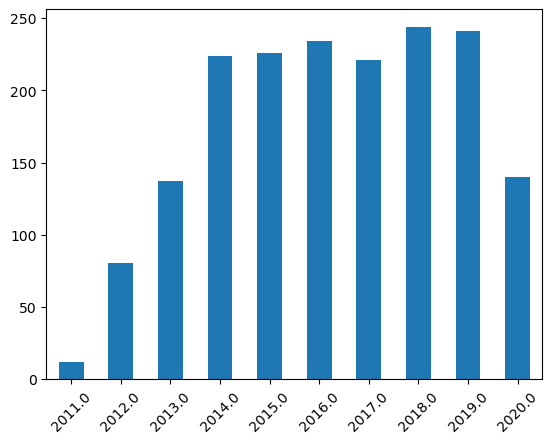

In [21]:
year_counts = df_train.launch_announced.value_counts().sort_index()

year_counts.plot(kind="bar", rot=45)
plt.show()

#### Misc price

There are many outliers which depicts the presence of some expensive devices. These devices are not removed because even this kind of devices are relevant for the task.

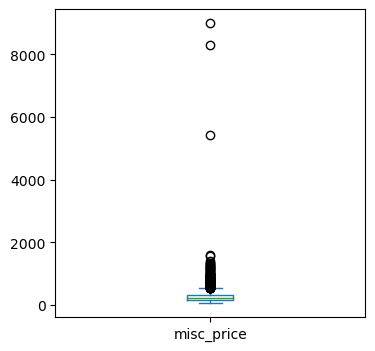

In [462]:
df_train.misc_price.plot.box(whis=1.5, figsize=(4,4))
plt.show()

In [22]:
misc_price = df.misc_price

print(f"Median: {misc_price.median()}")
print(f"Mean: {misc_price.mean()}")

misc_price.describe()

Median: 220.0
Mean: 282.26504536553466


count    2199.000000
mean      282.265045
std       333.677197
min        40.000000
25%       160.000000
50%       220.000000
75%       320.000000
max      9000.000000
Name: misc_price, dtype: float64

In [23]:
def compute_bin(x):
    if x > 400:
        return 3
    elif x > 300:
        return 2
    elif x > 300:
        return 1
    else:
        return 0
cat_price = misc_price.apply(compute_bin)
util_data.count_frequency_labels(cat_price).sort_index()

,Frequency,Count
0,73.26%,1611
2,12.82%,282
3,13.92%,306


Distribution of the price in different years.

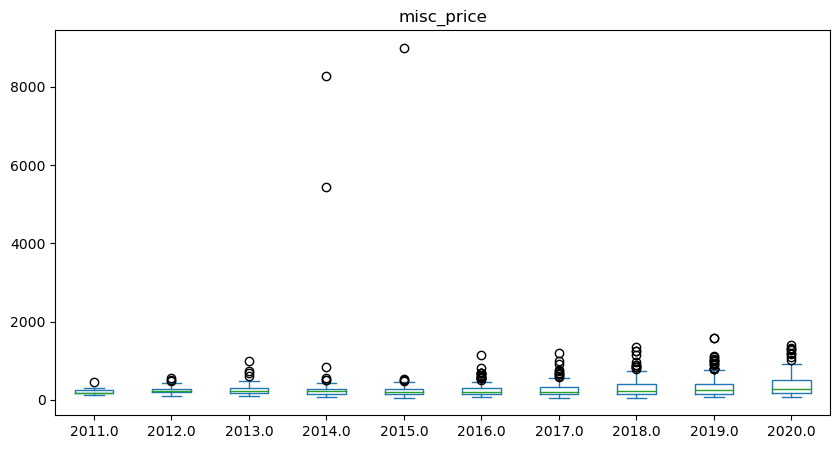

In [465]:
# show boxplot of misc_price for distinct launch_announced
df_train.plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()

#### Display resolution size


<Axes: xlabel='display_width', ylabel='display_height'>

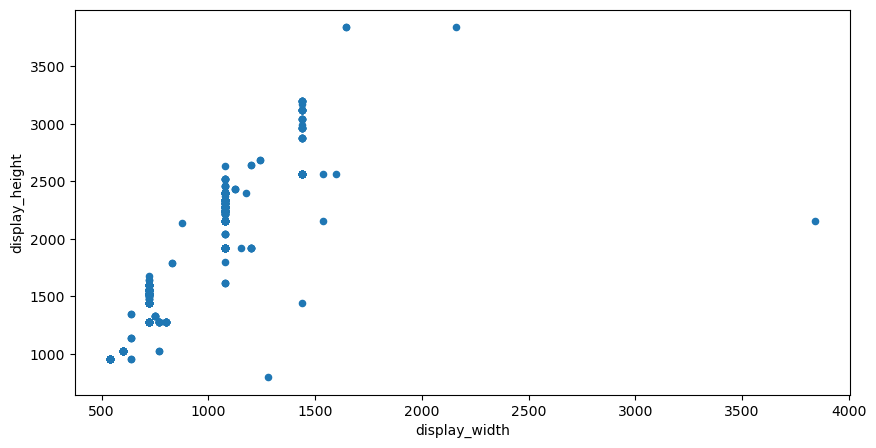

In [466]:
df_train.plot(kind="scatter", x="display_width", y="display_height", figsize=(10, 5))

### Plot of numerical feature correlations


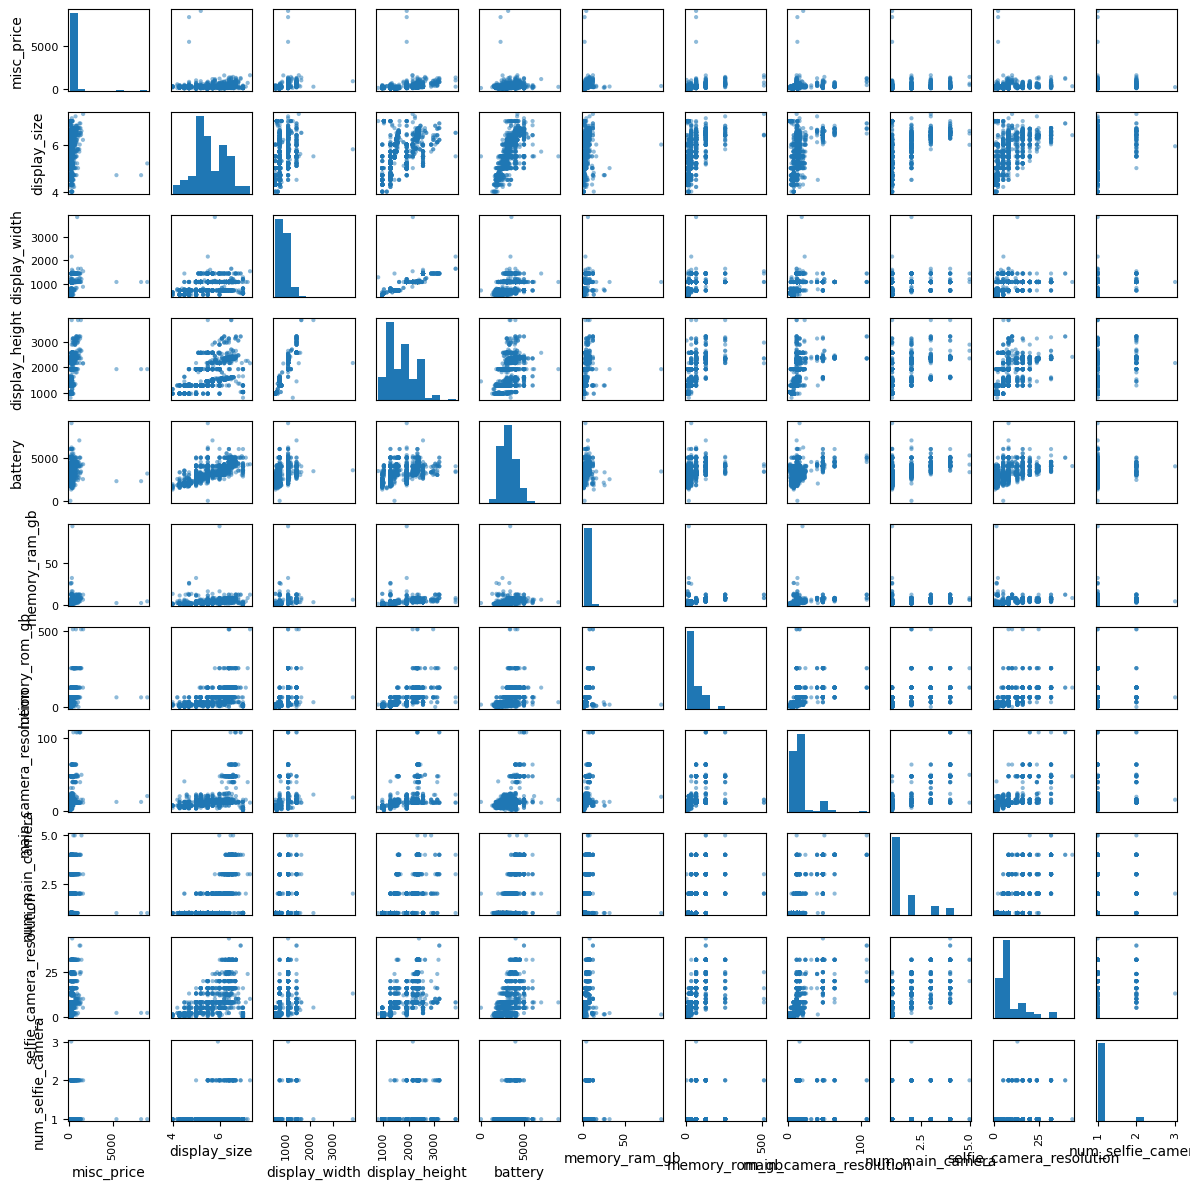

In [24]:
from pandas.plotting import scatter_matrix


attributes = [
    "misc_price",
    "display_size",
    "display_width",
    "display_height",
    "battery",
    "memory_ram_gb",
    "memory_rom_gb",
    "main_camera_resolution",
    "num_main_camera",
    "selfie_camera_resolution",
    "num_selfie_camera",
]
scatter_matrix(df_train[attributes], figsize=(12, 12))
plt.tight_layout()


### Correlation between data


In [468]:
df_train.corr(numeric_only=True)["misc_price"].sort_values(ascending=False)

misc_price                  1.000000
has_wireless_charging       0.350233
memory_rom_gb               0.320991
display_height              0.316126
display_width               0.304629
has_stereo_speakers         0.263849
has_wlan_5ghz               0.259468
has_nfc                     0.257360
has_oled_display            0.237341
memory_ram_gb               0.190528
is_waterproof               0.189180
main_camera_resolution      0.186775
num_main_camera             0.164192
selfie_camera_resolution    0.157903
num_selfie_camera           0.138093
display_size                0.119075
battery                     0.102584
launch_announced            0.071034
has_memory_card_slot       -0.248350
has_3.5mm_jack             -0.270318
Name: misc_price, dtype: float64

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.


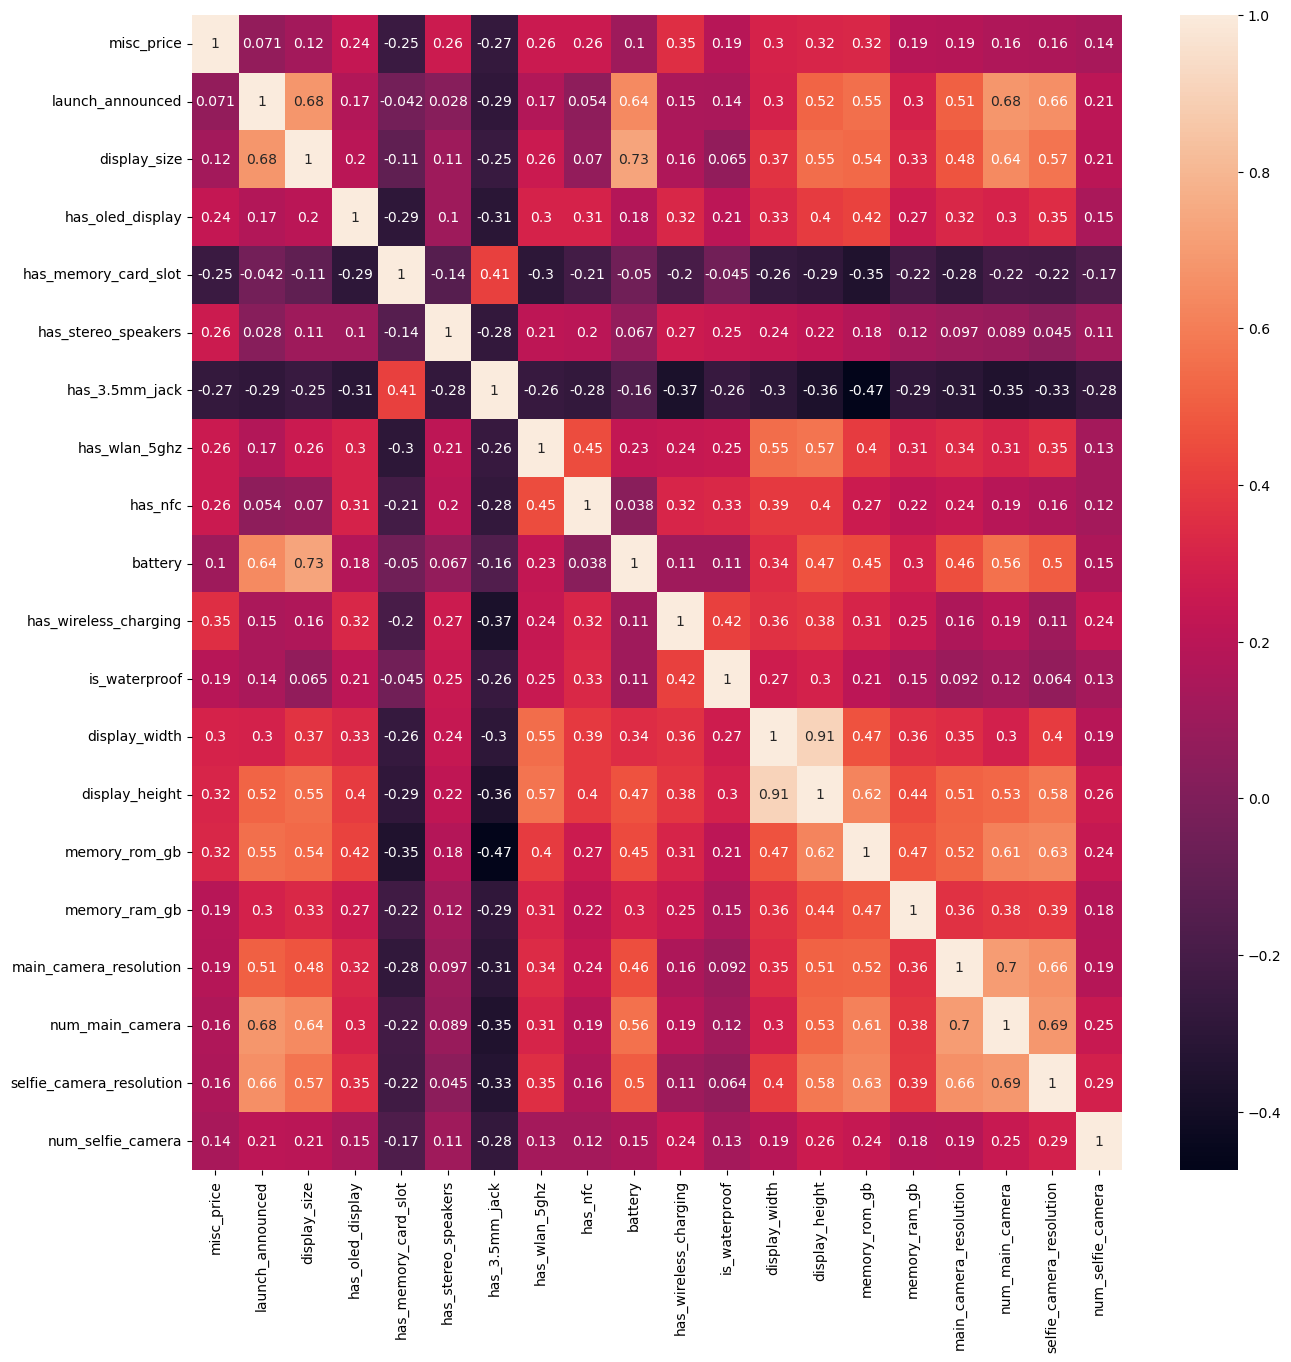

In [469]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(numeric_only=True), annot=True)
plt.show()


In [470]:
df_train.describe()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
count,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000
mean,284.120224,2016.299602,5.568709,0.234224,0.819784,0.139284,0.920409,0.536669,0.396816,3180.806140,0.066515,0.131325,907.241046,1721.404207,46.113701,3.332700,15.852985,1.514497,8.386583,1.047186
std,359.205270,2.310277,0.677026,0.423633,0.384477,0.346341,0.270735,0.498795,0.489376,879.845911,0.249251,0.337851,250.893314,518.976958,52.993320,3.324951,13.054332,0.879995,7.494577,0.214762
min,54.779943,2011.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,800.000000,1.000000,1.000000,2.000000,1.000000,0.300000,1.000000
25%,160.000000,2014.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2500.000000,0.000000,0.000000,720.000000,1280.000000,16.000000,2.000000,8.000000,1.000000,4.000000,1.000000
50%,220.000000,2016.000000,5.500000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3010.000000,0.000000,0.000000,768.000000,1600.000000,32.000000,3.000000,13.000000,1.000000,5.000000,1.000000
75%,315.565900,2018.000000,6.200000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4000.000000,0.000000,0.000000,1080.000000,2160.000000,64.000000,4.000000,16.000000,2.000000,10.000000,1.000000
max,9000.000000,2020.000000,7.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.000000,3840.000000,3840.000000,512.000000,94.000000,108.000000,5.000000,44.000000,3.000000


<Axes: >

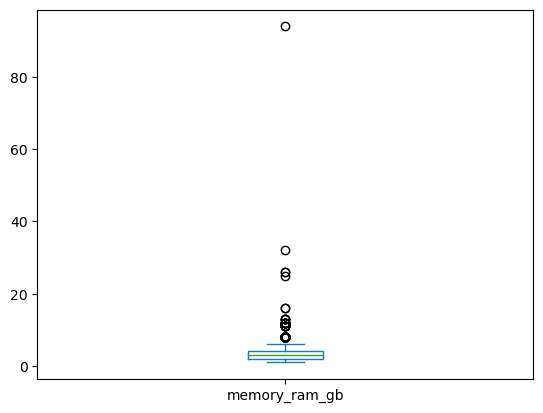

In [471]:
feat = "memory_ram_gb"
df_train[feat].plot.box()

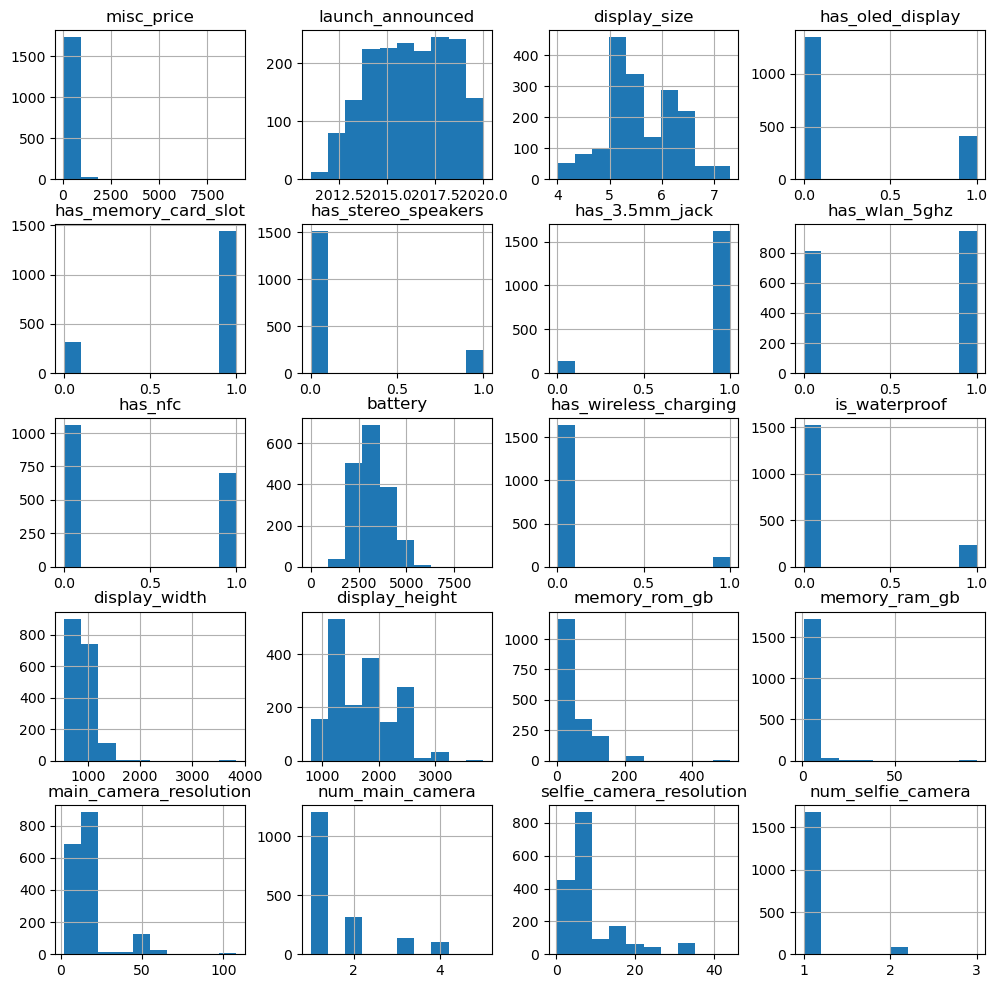

In [472]:
df_train.hist(figsize=(12, 12))
plt.show()

## Transform features

In [25]:
df_train = pd.read_csv("data/processed/gsm_train.csv")
df_test = pd.read_csv("data/processed/gsm_test.csv")

misc_price

In [26]:
# set environment variable to avoid memory leak
os.environ["OMP_NUM_THREADS"] = "7"
n_labels = 3

clip_fun = FunctionTransformer(np.clip, validate=False, check_inverse=False, feature_names_out="one-to-one", kw_args={"a_min": 50, "a_max": 1500})
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp, feature_names_out="one-to-one")
label_enc = KBinsDiscretizer(n_bins=n_labels, encode="ordinal", subsample=None, strategy="kmeans")

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)

display_size, battery, memory_ram_gb, memory_rom_gb, main_camera_resolution, selfie_camera_resolution

In [28]:
num_columns = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
# num_pipeline = make_pipeline(
#     FunctionTransformer(
#         np.log1p, validate=False, check_inverse=True, inverse_func=np.expm1, feature_names_out="one-to-one"
#     ),
#     RobustScaler(with_centering=True, unit_variance=True)
# )
num_pipeline = make_pipeline(
    StandardScaler()
    #QuantileTransformer(n_quantiles=1000, output_distribution="normal", random_state=rng),
)

display_width, display_height

In [29]:
def display_transformer(df: pd.DataFrame, df_res: pd.DataFrame, ord=2) -> pd.DataFrame:
    def compute_distance(x, y):
        return np.argmin(np.linalg.norm(x - y, ord=ord, axis=1))

    series_transform = df.apply(lambda x: df_res.index[compute_distance(x, df_res)], axis=1)
    df_transform = pd.DataFrame(series_transform, columns=["display_resolution"])
    assert isinstance(df_transform, pd.DataFrame)
    return df_transform

resolutions = {"qHD": [540, 960], "HD": [720, 1280], "FHD": [1080, 1920], "QHD": [1440, 2560]}
df_res = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

display_pipeline = make_pipeline(
    FunctionTransformer(display_transformer, kw_args={"df_res": df_res}, validate=False),
    OrdinalEncoder(categories=[list(resolutions.keys())])
)

network_technology, num_main_camera, num_selfie_camera

In [30]:
ordinal_columns = ["network_technology", "num_main_camera", "num_selfie_camera"]
ordinal_categories = [["3G", "4G", "5G"], [1., 2., 3., 4., 5.], [1., 2., 3.]]
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=ordinal_categories))

has_oled_display, has_memory_card_slot, has_stereo_speakers, has_3.5mm_jack, has_wlan_5ghz, has_nfc, has_wireless_charging, is_waterproof

In [31]:
id_columns = ["has_oled_display", "has_memory_card_slot", "has_stereo_speakers", "has_3.5mm_jack", "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]
id_pipeline = make_pipeline(FunctionTransformer(validate=False, feature_names_out="one-to-one"))

Pipeline for the transformation of the features.

In [32]:
pipeline = make_column_transformer(
    [label_pipeline, ["misc_price"]],
    [num_pipeline, num_columns],
    [id_pipeline, id_columns],
    [ordinal_pipeline, ordinal_columns],
    [display_pipeline, ["display_width", "display_height"]],
    verbose_feature_names_out=False
)
pipeline.set_output(transform="pandas")
pipeline.fit(df_train)

c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(check_inverse=False,
                                                                      feature_names_out='one-to-one',
                                                                      func=<function clip at 0x000001C38434AB80>,
                                                                      kw_args={'a_max': 1500,
                                                                               'a_min': 50})),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'ex...
                                ('pipeline-5',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function display_transformer at 0x000001C3937A8EE0>,
                                                                      kw_args={'df_res':      display_width  display_height
qHD            540             960
HD             720            1280
FHD           1080            1920
QHD           1440            2560})),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['qHD',
                                                                              'HD',
                                                                              'FHD',
                                                                              'QHD']]))]),
                                 ['display_width', 'display_height'])],
                  verbose_feature_names_out=False)

Save the pipeline for inverse transformation.

In [33]:
pickle.dump(pipeline, open("config/pipeline_stdscaler.pkl", "wb"))

In [34]:
bin_edges = np.exp(pipeline.transformers_[0][1][2].bin_edges_.item())
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f}")

Bin 0: 54.78 - 184.06
Bin 1: 184.06 - 375.63
Bin 2: 375.63 - 1500.00


In [35]:
train_preprocess = pipeline.transform(df_train)
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows before preprocessing: {train_preprocess.shape[0]}")

# train_preprocess = train_preprocess.drop(["has_memory_card_slot", "has_3.5mm_jack"], axis=1)

# keep only one instance between duplicates equal in all features
train_preprocess = train_preprocess.drop_duplicates(ignore_index=True, keep="first")
assert isinstance(train_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = train_preprocess.columns.drop("misc_price").to_list()
train_preprocess = train_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=True)
assert isinstance(train_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {train_preprocess.shape[0]}")
train_preprocess.head()

Number of rows before preprocessing: 1759
Number of rows after preprocessing: 1755


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,2.0,1.671445,1.499773,0.802435,1.545659,2.463256,3.151630,1,1,0,0,1,1,0,0,1.0,2.0,0.0,3.0
1,0.0,-0.101516,-0.728523,-0.400932,-0.568416,-0.218609,-0.051596,1,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
2,1.0,1.420276,2.068216,0.200752,1.545659,0.011265,1.016146,0,1,0,1,1,0,0,0,1.0,2.0,0.0,2.0
3,0.0,-0.840250,-0.046392,-0.701774,-0.719422,-0.601733,-0.452000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
4,2.0,-0.544756,-0.705786,0.200752,-0.266406,0.394389,-0.452000,1,0,0,1,1,1,0,0,1.0,0.0,0.0,2.0


In [36]:
util_data.count_frequency_labels(train_preprocess.misc_price).sort_index()

,Frequency,Count
0.0,35.95%,631
1.0,46.44%,815
2.0,17.61%,309


Preprocess test set.

In [37]:
test_preprocess = pipeline.transform(df_test)
assert isinstance(test_preprocess, pd.DataFrame)

# test_preprocess = test_preprocess.drop(["has_memory_card_slot", "has_3.5mm_jack"], axis=1)

print(f"Number of rows before preprocessing: {test_preprocess.shape[0]}")
# keep only one instance between duplicates equal in all features
test_preprocess = test_preprocess.drop_duplicates(ignore_index=True, keep="first")
assert isinstance(test_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = test_preprocess.columns.drop("misc_price").to_list()
test_preprocess = test_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=True)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {test_preprocess.shape[0]}")
test_preprocess.head()

Number of rows before preprocessing: 440
Number of rows after preprocessing: 440


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,1.0,-1.283490,-1.342442,-0.400932,-0.568416,-0.601733,-0.452000,0,0,0,1,0,0,0,0,0.0,0.0,0.0,1.0
1,0.0,-1.283490,-1.342442,-0.701774,-0.794924,-0.601733,-0.452000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
2,0.0,0.193977,-0.205556,-0.400932,-0.568416,-0.218609,-0.452000,0,1,0,1,1,0,0,0,1.0,0.0,0.0,1.0
3,0.0,1.021359,0.090034,0.200752,0.337616,-0.218609,1.016146,0,1,0,1,1,0,0,0,1.0,1.0,0.0,2.0
4,0.0,-0.840250,-0.944532,-0.400932,-0.568416,-0.601733,-0.452000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,0.0


In [38]:
# save train_preprocess
train_preprocess.to_csv("data/model/gsm_train_std.csv", index=False)
test_preprocess.to_csv("data/model/gsm_test_std.csv", index=False)

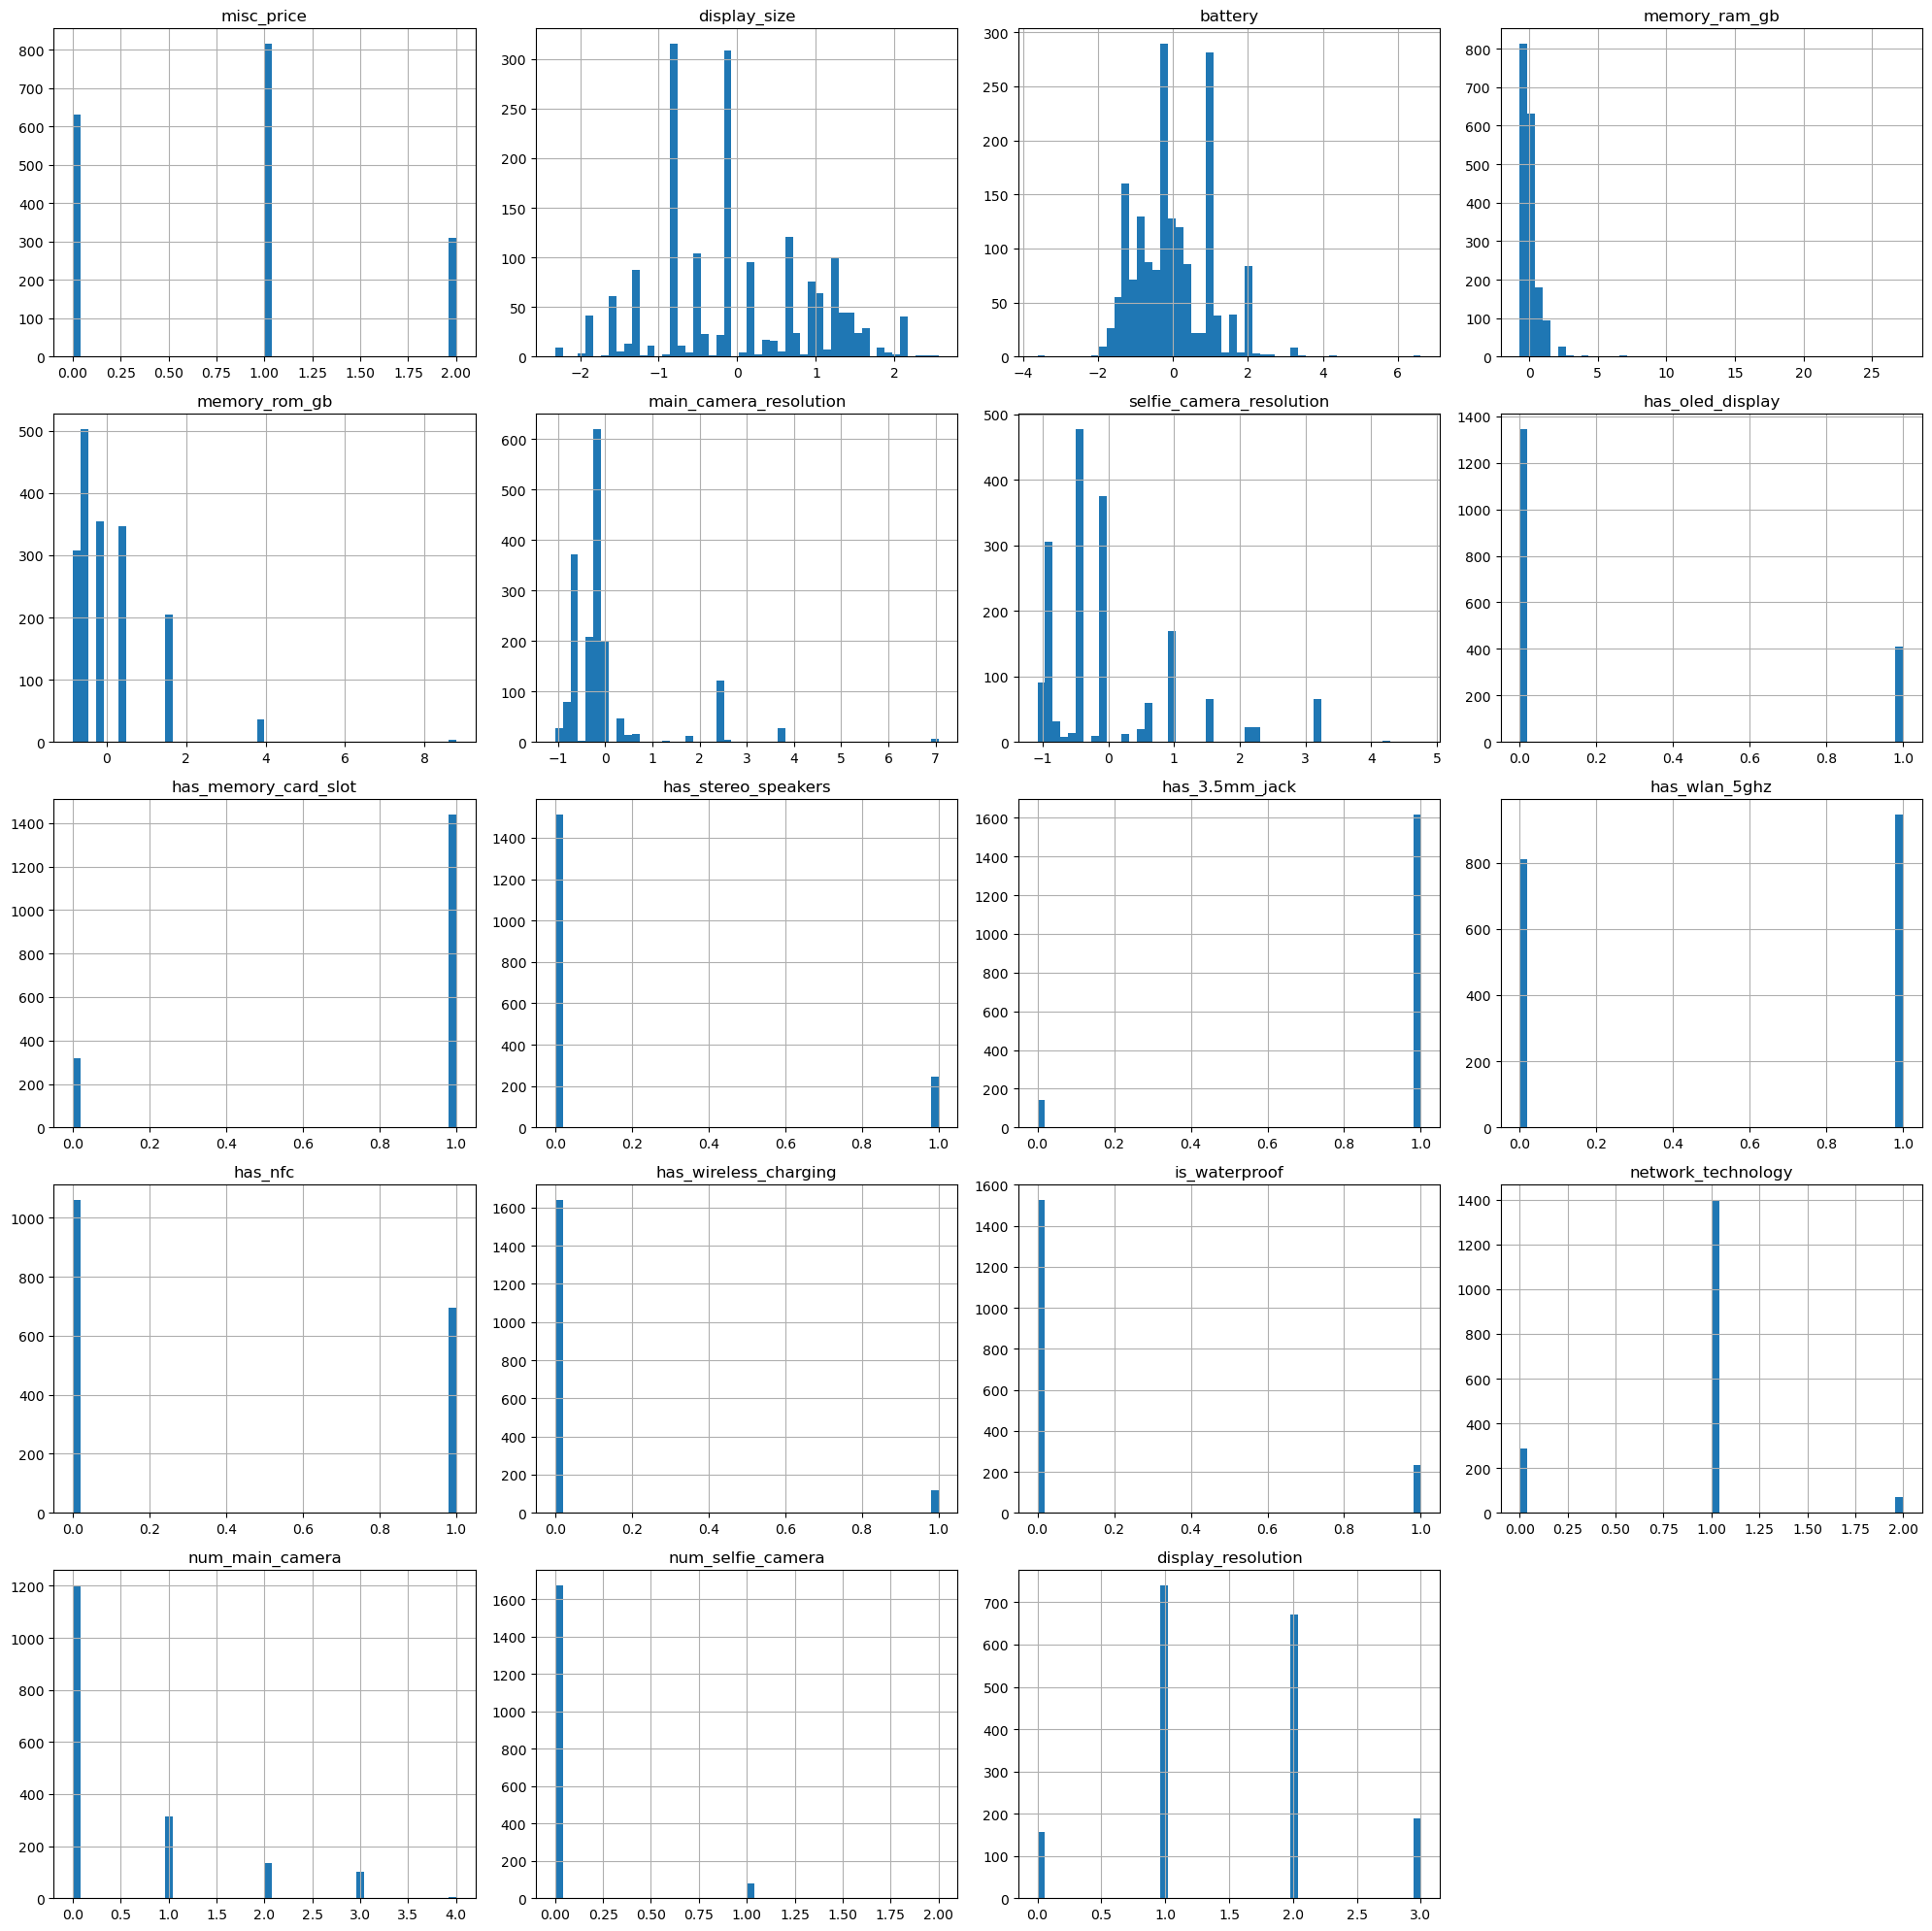

In [39]:
train_preprocess.hist(figsize=(20, 20), bins=50)
plt.tight_layout()